# Systemy uczące się - Zad. dom. 4: Ocena modeli predykcyjnych

### Autor rozwiązania
Uzupełnij poniższe informacje umieszczając swoje imię i nazwisko oraz numer indeksu:

In [ ]:
NAME = "Dominika Nowak"
ID = ""

Ten notebook zawiera zadania związane z oceną modeli predykcyjnych. Oprócz zadań programistycznych, notebook zawira również pytania, na które trzeba odpowiedzieć. Odpowiedzi nie muszą być długie, ale powinny być merytoryczne i odnosić się do omawianych zagadnień. W tym zadaniu domowym należy odpowiedzieć na WSZYSTKIE pytania.


## Format danych
W tym zadaniu domyślnym typem danych będą macierze (`np.ndarray`) o rozmiarze `(n, c)`, gdzie `n` to liczba obserwacji, a `c` to liczba klas. Wartości w macierzy będą reprezentować:

- w przypadku `y` - prawdziwe klasy (wartości binarne). Na przykład:
    ```
    [
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
    ]
    ```
    oznacza, że pierwsza i trzecia obserwacja należą do klasy 0, a druga do klasy 2.

- w przypadku `y_hat` - predykcje modelu. Wartości w macierzy mogą reprezentować:
    * prawdopodobieństwa przynależności do danej klasy (wartości z przedziału `[0, 1]`). Na przykład:
        ```
        [
            [0.9, 0.1, 0.0],
            [0.1, 0.2, 0.7],
            [0.8, 0.2, 0.0],
        ]
        ```
        oznacza, że model przewiduje, że pierwsza obserwacja należy do klasy 0 z prawdopodobieństwem 0.9, a do klasy 1 z prawdopodobieństwem 0.1.
    
    * predykcje (wartości binarne), gdzie wartość `1` oznacza przynależność do danej klasy, a wartość `0` jej brak.
        ```
        [
            [0, 1, 0],
            [0, 0, 1],
            [0, 1, 0],
        ]
        ```
        oznacza, że model przewiduje, że pierwsza obserwacja należy do klasy 1, a druga do klasy 2.

# Zadanie 1: Punktowe miary oceny klasyfikatorów

Zadanie polega na zaimplementowaniu funkcji obliczających punktowe miary oceny klasyfikatorów, takich jak:
- dokładność (accuracy),
- precyzja (precision),
- czułość (recall),
- specyficzność (specificity),
- F1,
- G-mean,
- balanced accuracy.

Uwagi:
- Do rozwiązania zadania można wykorzystać wyłącznie bibliotekę `numpy`.
- Na potrzeby zadania domowego można założyć, że klasyfikacja jest wieloklasowa, ale jednoetykietowa (tj. każda obserwacja należy do dokładnie jednej klasy).
- W przypadku, gdy mianownik w równaniu miary oceny jest równy 0, wartość miary powinna wynosić 0.
- Podpowiedź: przy obliczaniu wielu miar warto zaimplementować funkcję pomocniczą, która oblicza macierz pomyłek.

In [2]:
from typing import Literal

import numpy as np

In [3]:
y = np.eye(2, dtype=int)[np.repeat([0, 1], 50)]
y_hat_0 = np.tile([1, 0], (100, 1))
y_hat_1 = np.tile([0, 1], (100, 1))

In [4]:
def accuracy(y_hat: np.ndarray, y: np.ndarray) -> float:
    """Funkcja obliczająca dokładność klasyfikacji (accuracy). Funkcja powinna wspierać klasyfikację wieloklasową.

    Args:
        y_hat (np.ndarray): Macierz z predykacjami modelu o wymiarach `(n, c)`.
        y (np.ndarray): Macierz z prawdziwymi klasami o wymiarach `(n, c)`.

    Returns:
        float: Dokładność klasyfikacji.
    """
    return np.mean(np.argmax(y_hat, axis=1) == np.argmax(y, axis=1))


In [5]:
def comfusion_matrix(y_hat: np.ndarray, y: np.ndarray, mode: Literal["micro", "macro"] = "micro") -> np.array:
    """Funkcja obliczająca macierz pomyłek dla klasyfikacji wieloklasowej.

    Args:
        y_hat (np.ndarray): Macierz z predykacjami modelu o wymiarach `(n, c)`.
        y (np.ndarray): Macierz z prawdziwymi klasami o wymiarach `(n, c)`.
        mode ("micro" | "macro"): Typ wyliczania macierzy. Domyślnie "micro".

    Returns:
        np.ndarray:
            - Jeśli `mode="micro"`, zwraca pojedynczą macierz o wymiarach `(c, c)`.[true_label, pred_label] 0,0 -> TN, 1,1 -> TP, 0,1 -> FP, 1,0 -> FN
            - Jeśli `mode="macro"`, zwraca tensor o wymiarach `(c, c, c)`, gdzie
              każda macierz odpowiada jednej klasie w podejściu one-vs-all.
    """
    n, c = y.shape
    y_true_labels = np.argmax(y, axis=1)
    y_pred_labels = np.argmax(y_hat, axis=1)

    if mode == "micro":
        confusion_matrix = np.zeros(2, dtype=int)
        confusion_matrix[0] = np.sum(y_true_labels == y_pred_labels)
        confusion_matrix[1] = n
        return confusion_matrix

    elif mode == "macro":
        macro_matrices = np.zeros((c, 2, 2), dtype=int)
        for class_idx in range(c):
            binary_y_true = (y_true_labels == class_idx).astype(int)
            binary_y_pred = (y_pred_labels == class_idx).astype(int)
            for true_val, pred_val in zip(binary_y_true, binary_y_pred):
                macro_matrices[class_idx, true_val, pred_val] += 1
        return macro_matrices

    else:
        raise ValueError("Niepoprawny tryb")


In [6]:
def precision(y_hat: np.ndarray, y: np.ndarray, average: Literal["micro", "macro"] = "micro") -> float:
    """Funkcja obliczająca precyzję klasyfikacji (precision). Funkcja powinna wspierać klasyfikację wieloklasową.

    Args:
        y_hat (np.ndarray): Macierz z predykacjami modelu o wymiarach `(n, c)`.
        y (np.ndarray): Macierz z prawdziwymi klasami o wymiarach `(n, c)`.
        average ("micro" | "macro"): Typ uśredniania wyników. Domyślnie "micro".

    Returns:
        float: Precyzja klasyfikacji.
    """
    conf_matrix = comfusion_matrix(y_hat, y, mode=average)

    if average == "micro":
        tp, tpfp  = conf_matrix[0], conf_matrix[1]
        return tp / tpfp if tpfp > 0 else 0.0

    elif average == "macro":
        c = conf_matrix.shape[0]
        precisions = []
        for i in range(c):
            tp = conf_matrix[i, 1, 1]
            fp = conf_matrix[i, 0, 1]
            precisions.append(tp / (tp + fp) if (tp + fp) > 0 else 0.0)
        return np.mean(precisions)

    else:
        raise ValueError("Niepoprawny tryb uśredniania")

In [7]:
def recall(y_hat: np.ndarray, y: np.ndarray, average: Literal["micro", "macro"] = "micro") -> float:
    """Funkcja obliczająca czułość klasyfikacji (recall). Funkcja powinna wspierać klasyfikację wieloklasową.

    Args:
        y_hat (np.ndarray): Macierz z predykacjami modelu o wymiarach `(n, c)`.
        y (np.ndarray): Macierz z prawdziwymi klasami o wymiarach `(n, c)`.
        average ("micro" | "macro"): Typ uśredniania wyników. Domyślnie "micro".

    Returns:
        float: Precyzja klasyfikacji.
    """
    conf_matrix = comfusion_matrix(y_hat, y, mode=average)

    if average == "micro":
        tp, tpfn  = conf_matrix[0], conf_matrix[1]
        return tp / tpfn if tpfn > 0 else 0.0

    elif average == "macro":
        c = conf_matrix.shape[0]
        recalls = []
        for i in range(c):
            tp = conf_matrix[i, 1, 1]
            fn = conf_matrix[i, 1, 0]
            recalls.append(tp / (tp + fn) if (tp + fn) > 0 else 0.0)
        return np.mean(recalls)

    else:
        raise ValueError("Niepoprawny tryb uśredniania")

In [8]:
def specificity(y_hat: np.ndarray, y: np.ndarray, average: Literal["micro", "macro"] = "micro") -> float:
    """Funkcja obliczająca specyficzność klasyfikacji (specificity). Funkcja powinna wspierać klasyfikację wieloklasową.

    Args:
        y_hat (np.ndarray): Macierz z predykacjami modelu o wymiarach `(n, c)`.
        y (np.ndarray): Macierz z prawdziwymi klasami o wymiarach `(n, c)`.
        average ("micro" | "macro"): Typ uśredniania wyników. Domyślnie "micro".

    Returns:
        float: Specyficzność klasyfikacji.
    """
    conf_matrix = comfusion_matrix(y_hat, y, mode=average)

    if average == "micro": # bez znajomości klasy negatywnej obliczane analogicznie do precision i recall
                           # jako TN brane wszytskie poprawnie zaklasyfikowane przypadki, a jako TN + FP wszystkie przypadki
        tn, tnfp  = conf_matrix[0], conf_matrix[1]
        return tn / tnfp if tnfp > 0 else 0.0

    elif average == "macro":
        c = conf_matrix.shape[0]
        specificities = []
        for i in range(c):
            tn = conf_matrix[i, 0, 0]
            fp = conf_matrix[i, 0, 1]
            specificities.append(tn / (tn + fp) if (tn + fp) > 0 else 0.0)
        return np.mean(specificities)

    else:
        raise ValueError("Niepoprawny tryb uśredniania")

Zatrzymaj się w tym miejscu na chwilę i poeksperymentuj z dotychczas zaimplementowanymi funkcjami i danymi testowymi. Spróbuj zrozumieć, jak działają poszczególne miary oceny klasyfikatorów. Możesz ograniczyć się do uśredniania wyników "micro".

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

acc = accuracy(y_hat_0, y)
skl_acc = accuracy_score(np.argmax(y, axis=1), np.argmax(y_hat_0, axis=1))

precision_mirco = precision(y_hat_0, y, average="micro")
skl_precision_micro = precision_score(np.argmax(y, axis=1), np.argmax(y_hat_0, axis=1), average="micro", zero_division=0)
precision_marco = precision(y_hat_0, y, average="macro")
skl_precision_macro = precision_score(np.argmax(y, axis=1), np.argmax(y_hat_0, axis=1), average="macro", zero_division=0)


recall_micro = recall(y_hat_0, y, average="micro")
skl_recall_micro = recall_score(np.argmax(y, axis=1), np.argmax(y_hat_0, axis=1), average="micro", zero_division=0)
recall_macro = recall(y_hat_0, y, average="macro")
skl_recall_macro = recall_score(np.argmax(y, axis=1), np.argmax(y_hat_0, axis=1), average="macro", zero_division=0)

specificity_micro = specificity(y_hat_0, y, average="micro")
specificity_macro = specificity(y_hat_0, y, average="macro")


print(f"Accuracy:\t\t\t{acc:.4f}\tscikit-learn: {skl_acc:.4f}")
print(f"Micro-averaging precision:\t{precision_mirco:.4f}\tscikit-learn: {skl_precision_micro:.4f}")
print(f"Macro-averaging precision:\t{precision_marco:.4f}\tscikit-learn: {skl_precision_macro:.4f}")
print(f"Micro-averaging recall:\t\t{recall_micro:.4f}\tscikit-learn: {skl_recall_micro:.4f}")
print(f"Macro-averaging recall:\t\t{recall_macro:.4f}\tscikit-learn: {skl_recall_macro:.4f}")
print(f"Micro-averaging specificity:\t{specificity_micro:.4f}")
print(f"Macro-averaging specificity:\t{specificity_macro:.4f}")

Accuracy:			0.5000	scikit-learn: 0.5000
Micro-averaging precision:	0.5000	scikit-learn: 0.5000
Macro-averaging precision:	0.2500	scikit-learn: 0.2500
Micro-averaging recall:		0.5000	scikit-learn: 0.5000
Macro-averaging recall:		0.5000	scikit-learn: 0.5000
Micro-averaging specificity:	0.5000
Macro-averaging specificity:	0.5000


In [10]:
y_ideal = np.eye(3)[np.array([0, 1, 2, 0, 1, 2])]
y_hat_ideal = np.eye(3)[np.array([0, 1, 2, 0, 1, 2])]

acc = accuracy(y_hat_ideal, y_ideal)
skl_acc = accuracy_score(np.argmax(y_ideal, axis=1), np.argmax(y_hat_ideal, axis=1))

precision_mirco = precision(y_hat_ideal, y_ideal, average="micro")
skl_precision_micro = precision_score(np.argmax(y_ideal, axis=1), np.argmax(y_hat_ideal, axis=1), average="micro", zero_division=0)
precision_marco = precision(y_hat_ideal, y_ideal, average="macro")
skl_precision_macro = precision_score(np.argmax(y_ideal, axis=1), np.argmax(y_hat_ideal, axis=1), average="macro", zero_division=0)


recall_micro = recall(y_hat_ideal, y_ideal, average="micro")
skl_recall_micro = recall_score(np.argmax(y_ideal, axis=1), np.argmax(y_hat_ideal, axis=1), average="micro", zero_division=0)
recall_macro = recall(y_hat_ideal, y_ideal, average="macro")
skl_recall_macro = recall_score(np.argmax(y_ideal, axis=1), np.argmax(y_hat_ideal, axis=1), average="macro", zero_division=0)

specificity_micro = specificity(y_hat_ideal, y_ideal, average="micro")
specificity_macro = specificity(y_hat_ideal, y_ideal, average="macro")


print(f"Accuracy:\t\t\t{acc:.4f}\tscikit-learn: {skl_acc:.4f}")
print(f"Micro-averaging precision:\t{precision_mirco:.4f}\tscikit-learn: {skl_precision_micro:.4f}")
print(f"Macro-averaging precision:\t{precision_marco:.4f}\tscikit-learn: {skl_precision_macro:.4f}")
print(f"Micro-averaging recall:\t\t{recall_micro:.4f}\tscikit-learn: {skl_recall_micro:.4f}")
print(f"Macro-averaging recall:\t\t{recall_macro:.4f}\tscikit-learn: {skl_recall_macro:.4f}")
print(f"Micro-averaging specificity:\t{specificity_micro:.4f}")
print(f"Macro-averaging specificity:\t{specificity_macro:.4f}")


Accuracy:			1.0000	scikit-learn: 1.0000
Micro-averaging precision:	1.0000	scikit-learn: 1.0000
Macro-averaging precision:	1.0000	scikit-learn: 1.0000
Micro-averaging recall:		1.0000	scikit-learn: 1.0000
Macro-averaging recall:		1.0000	scikit-learn: 1.0000
Micro-averaging specificity:	1.0000
Macro-averaging specificity:	1.0000


In [11]:
np.random.seed(83)
y_random = np.eye(3)[np.array([0, 1, 2, 0, 1, 2])]
y_hat_random = np.eye(3)[np.random.choice([0, 1, 2], size=6)]

acc = accuracy(y_hat_random, y_random)
skl_acc = accuracy_score(np.argmax(y_random, axis=1), np.argmax(y_hat_random, axis=1))

precision_mirco = precision(y_hat_random, y_random, average="micro")
skl_precision_micro = precision_score(np.argmax(y_random, axis=1), np.argmax(y_hat_random, axis=1), average="micro", zero_division=0)
precision_marco = precision(y_hat_random, y_random, average="macro")
skl_precision_macro = precision_score(np.argmax(y_random, axis=1), np.argmax(y_hat_random, axis=1), average="macro", zero_division=0)


recall_micro = recall(y_hat_random, y_random, average="micro")
skl_recall_micro = recall_score(np.argmax(y_random, axis=1), np.argmax(y_hat_random, axis=1), average="micro", zero_division=0)
recall_macro = recall(y_hat_random, y_random, average="macro")
skl_recall_macro = recall_score(np.argmax(y_random, axis=1), np.argmax(y_hat_random, axis=1), average="macro", zero_division=0)

specificity_micro = specificity(y_hat_random, y_random, average="micro")
specificity_macro = specificity(y_hat_random, y_random, average="macro")


print(f"Accuracy:\t\t\t{acc:.4f}\tscikit-learn: {skl_acc:.4f}")
print(f"Micro-averaging precision:\t{precision_mirco:.4f}\tscikit-learn: {skl_precision_micro:.4f}")
print(f"Macro-averaging precision:\t{precision_marco:.4f}\tscikit-learn: {skl_precision_macro:.4f}")
print(f"Micro-averaging recall:\t\t{recall_micro:.4f}\tscikit-learn: {skl_recall_micro:.4f}")
print(f"Macro-averaging recall:\t\t{recall_macro:.4f}\tscikit-learn: {skl_recall_macro:.4f}")
print(f"Micro-averaging specificity:\t{specificity_micro:.4f}")
print(f"Macro-averaging specificity:\t{specificity_macro:.4f}")


Accuracy:			0.1667	scikit-learn: 0.1667
Micro-averaging precision:	0.1667	scikit-learn: 0.1667
Macro-averaging precision:	0.0667	scikit-learn: 0.0667
Micro-averaging recall:		0.1667	scikit-learn: 0.1667
Macro-averaging recall:		0.1667	scikit-learn: 0.1667
Micro-averaging specificity:	0.1667
Macro-averaging specificity:	0.5833


In [12]:
y_one_class = np.eye(3)[np.array([0, 1, 2, 0, 1, 2])]
y_hat_one_class = np.eye(3)[np.array([0, 0, 0, 0, 0, 0])]

acc = accuracy(y_hat_one_class, y_one_class)
skl_acc = accuracy_score(np.argmax(y_one_class, axis=1), np.argmax(y_hat_one_class, axis=1))

precision_mirco = precision(y_hat_one_class, y_one_class, average="micro")
skl_precision_micro = precision_score(np.argmax(y_one_class, axis=1), np.argmax(y_hat_one_class, axis=1), average="micro", zero_division=0)
precision_marco = precision(y_hat_one_class, y_one_class, average="macro")
skl_precision_macro = precision_score(np.argmax(y_one_class, axis=1), np.argmax(y_hat_one_class, axis=1), average="macro", zero_division=0)


recall_micro = recall(y_hat_one_class, y_one_class, average="micro")
skl_recall_micro = recall_score(np.argmax(y_one_class, axis=1), np.argmax(y_hat_one_class, axis=1), average="micro", zero_division=0)
recall_macro = recall(y_hat_one_class, y_one_class, average="macro")
skl_recall_macro = recall_score(np.argmax(y_one_class, axis=1), np.argmax(y_hat_one_class, axis=1), average="macro", zero_division=0)

specificity_micro = specificity(y_hat_one_class, y_one_class, average="micro")
specificity_macro = specificity(y_hat_one_class, y_one_class, average="macro")


print(f"Accuracy:\t\t\t{acc:.4f}\tscikit-learn: {skl_acc:.4f}")
print(f"Micro-averaging precision:\t{precision_mirco:.4f}\tscikit-learn: {skl_precision_micro:.4f}")
print(f"Macro-averaging precision:\t{precision_marco:.4f}\tscikit-learn: {skl_precision_macro:.4f}")
print(f"Micro-averaging recall:\t\t{recall_micro:.4f}\tscikit-learn: {skl_recall_micro:.4f}")
print(f"Macro-averaging recall:\t\t{recall_macro:.4f}\tscikit-learn: {skl_recall_macro:.4f}")
print(f"Micro-averaging specificity:\t{specificity_micro:.4f}")
print(f"Macro-averaging specificity:\t{specificity_macro:.4f}")

Accuracy:			0.3333	scikit-learn: 0.3333
Micro-averaging precision:	0.3333	scikit-learn: 0.3333
Macro-averaging precision:	0.1111	scikit-learn: 0.1111
Micro-averaging recall:		0.3333	scikit-learn: 0.3333
Macro-averaging recall:		0.3333	scikit-learn: 0.3333
Micro-averaging specificity:	0.3333
Macro-averaging specificity:	0.6667


Odpowiedz na pytanie

1. Czy zaimplementowane funkcje mogą być wystarczające do oceny modeli klasyfikacyjnych? Jeśli nie, to dlaczego? Jeśli tak, to w jakich przypadkach?

Ostateczny wybór metryki zależy od tego, jak dokładnych ocen oczekujemy oraz jak zbilansowane są dane, na których testujemy model. Accuracy jest często stosowaną podstawową metryką, jednak może prowadzić do mylących wyników, gdy dane są silnie niezbilansowane a model zawsze przewiduje klasę dominującą. Pozostałe metryki raczej dla większości przypadków nie będą wystarczające, zwłaszcza gdy nie ma podziału na klasy negatywne i pozytywne. Jeżeli taki podział by występował, to mogą się one przydać jako wstępne lub dodatkowe metryki np. maksymalizowanie precision będzie miało sens gdy zależy nam aby nie dostawać przypadków fałszywie pozytywnych (diagnozowanie medyczne), a recall gdy chcemy wyłapać jak najwięcej przypadków pozytywnych, nawet kosztem "fałszywych alarmów" (wykrywanie przestępstw).

$F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$

In [13]:
def f1(y_hat: np.ndarray, y: np.ndarray, average: Literal["micro", "macro"] = "micro") -> float:
    """Funkcja obliczająca miarę F1. Funkcja powinna wspierać klasyfikację wieloklasową.

    Args:
        y_hat (np.ndarray): Macierz z predykacjami modelu o wymiarach `(n, c)`.
        y (np.ndarray): Macierz z prawdziwymi klasami o wymiarach `(n, c)`.
        average ("micro" | "macro"): Typ uśredniania wyników. Domyślnie "micro".

    Returns:
        float: Specyficzność klasyfikacji.
    """
    return 2 * (precision(y_hat, y, average) * recall(y_hat, y, average)) / (precision(y_hat, y, average) + recall(y_hat, y, average)) if (precision(y_hat, y, average) + recall(y_hat, y, average)) > 0 else 0.0

In [14]:
def g_mean(y_hat: np.ndarray, y: np.ndarray, average: Literal["micro", "macro"] = "micro") -> float:
    """Funkcja obliczająca miarę G-mean. Funkcja powinna wspierać klasyfikację wieloklasową.

    Args:
        y_hat (np.ndarray): Macierz z predykacjami modelu o wymiarach `(n, c)`.
        y (np.ndarray): Macierz z prawdziwymi klasami o wymiarach `(n, c)`.
        average ("micro" | "macro"): Typ uśredniania wyników. Domyślnie "micro".

    Returns:
        float: Specyficzność klasyfikacji.
    """
    return np.sqrt(specificity(y_hat, y, average=average) * recall(y_hat, y, average=average)) # nie wiedziałam czy korzystać z micro czy macro, więc zostawiłam obie możliwości jak w sklearnie

In [15]:
def balanced_accuracy(y_hat: np.ndarray, y: np.ndarray) -> float:
    """Funkcja obliczająca zbalansowaną dokładność klasyfikacji. Funkcja powinna wspierać klasyfikację wieloklasową.

    Args:
        y_hat (np.ndarray): Macierz z predykacjami modelu o wymiarach `(n, c)`.
        y (np.ndarray): Macierz z prawdziwymi klasami o wymiarach `(n, c)`.

    Returns:
        float: Zbalansowana dokładność klasyfikacji.
    """
    return np.mean([recall(y_hat, y, average="macro"), specificity(y_hat, y, average="macro")])

Sprawdź jak zaimplementowane funkcje działają na 3 zbiorach testowych o różnej charakterystyce.

### Scenariusz 1

In [16]:
# dane silnie niezbalansowane: 80% klasa 0, 10% klasa 1, 5% klasa 2, 5% klasa 3

# model przewiduje zawsze klasę 0
y_hat_all_0 = np.eye(4)[np.array([0] * 100)]

# model poprawnie przewiduje klasy 0 i 1, ale zawsze myli klasy 2 i 3
y_hat_partial = np.eye(4)[np.array([0] * 80 + [1] * 10 + [3] * 5 + [2] * 5)]

### Scenariusz 2

In [17]:
# dane niezbalansowane: 50 próbek klasy 0, 25 klasy 1, 15 klasy 2, 10 klasy 3


# Model przewiduje 60 próbek jako klasa 0, reszta losowo
np.random.seed(42)
y_hat = np.eye(4)[np.array([0] * 60 + list(np.random.choice([1, 2, 3], size=40)))]

### Scenariusz 3

In [18]:
# dane niezbalansowane jak w Scenariuszu 2
y = np.eye(4)[np.array([0] * 50 + [1] * 25 + [2] * 15 + [3] * 10)]

# model losowy
np.random.seed(0)
y_hat = np.eye(4)[np.random.choice([0, 1, 2, 3], size=100)]

In [19]:
from sklearn.metrics import f1_score, balanced_accuracy_score, recall_score
from imblearn.metrics import geometric_mean_score

scenarios = {
    "Scenario 1.0": (np.eye(4)[np.array([0] * 80 + [1] * 10 + [2] * 5 + [3] * 5)], y_hat_all_0),
    "Scenario 1.1": (np.eye(4)[np.array([0] * 80 + [1] * 10 + [2] * 5 + [3] * 5)], y_hat_partial),
    "Scenario 2": (np.eye(4)[np.array([0] * 50 + [1] * 25 + [2] * 15 + [3] * 10)], y_hat),
    "Scenario 3": (y, y_hat)
}

for name, (y_true, y_pred) in scenarios.items():
    print(f"{name}:")
    
    f1_macro = f1(y_pred, y_true, average="macro")
    skl_f1_macro = f1_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), average="macro")
    
    gmean_macro = g_mean(y_pred, y_true, average="macro")
    skl_gmean_macro = geometric_mean_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), average="macro")
    
    gmean_micro = g_mean(y_pred, y_true, average="micro")
    skl_gmean_micro = geometric_mean_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), average="micro")
    
    bal_acc = balanced_accuracy(y_pred, y_true)
    skl_bal_acc = balanced_accuracy_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    
    recall_macro = recall(y_pred, y_true, average="macro")
    skl_recall_macro = recall_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), average="macro")
    
    print(f"  F1 Macro:\t{f1_macro:.4f} (sklearn: {skl_f1_macro:.4f})")
    print(f"  G-Mean Macro:	{gmean_macro:.4f} imblearn: {skl_gmean_macro:.4f})")
    print(f"  G-Mean Micro:	{gmean_micro:.4f} (imblearn: {skl_gmean_micro:.4f})")
    print(f"  Balanced Acc:	{bal_acc:.4f} (sklearn: {skl_bal_acc:.4f})")
    print(f"  Recall Macro:	{recall_macro:.4f} (sklearn: {skl_recall_macro:.4f})") # w sklearn balanced accuracy jest zaimplementowane jako:
                                                                                   # It is defined as the average of recall obtained on each class.
                                                                                   # czyli recall z macro-averaging 
    print()


Scenario 1.0:
  F1 Macro:	0.2222 (sklearn: 0.2222)
  G-Mean Macro:	0.4330 imblearn: 0.4330)
  G-Mean Micro:	0.8000 (imblearn: 0.8641)
  Balanced Acc:	0.5000 (sklearn: 0.2500)
  Recall Macro:	0.2500 (sklearn: 0.2500)

Scenario 1.1:
  F1 Macro:	0.5000 (sklearn: 0.5000)
  G-Mean Macro:	0.6977 imblearn: 0.6977)
  G-Mean Micro:	0.9000 (imblearn: 0.9327)
  Balanced Acc:	0.7368 (sklearn: 0.5000)
  Recall Macro:	0.5000 (sklearn: 0.5000)

Scenario 2:
  F1 Macro:	0.2511 (sklearn: 0.2228)
  G-Mean Macro:	0.4407 imblearn: 0.4407)
  G-Mean Micro:	0.2400 (imblearn: 0.4233)
  Balanced Acc:	0.5034 (sklearn: 0.2600)
  Recall Macro:	0.2600 (sklearn: 0.2600)

Scenario 3:
  F1 Macro:	0.2511 (sklearn: 0.2228)
  G-Mean Macro:	0.4407 imblearn: 0.4407)
  G-Mean Micro:	0.2400 (imblearn: 0.4233)
  Balanced Acc:	0.5034 (sklearn: 0.2600)
  Recall Macro:	0.2600 (sklearn: 0.2600)



### Pytania

Odpowiedz na pytania:
1. Jakie różnice daje uśrednianie wyników "micro" w porównaniu do "macro"? Dla jakich danych warto użyć jednego, a dla jakich drugiego sposobu uśredniania wyników?
    
    - W uśrednaniu wyników "micro" bierzemy pod uwagę prawidłowe i nieprawidłowe klasyfikacje dla wszytskich klas. Takie podejście jest bardziej ogólne. Dla niezbilansowanych danych wyniki dla klasy dominującej mają wyższe znaczenie dla ostatecznej wartości metryki. Może być przydatniejsze, gdy zależy nam aby ta relacja dominacji była uwzględniona w ocenie jakości modelu(ważniejsze jest dla nas aby prawidłowo klasyfikoważ klasy o wyższej reprezentacji w danych). Macro-averaging wylicza metrykę dla każdej klasy z osobna i uśrednia tą wartość, przez co jakość wszytskich klas ma równą wagę do końowego wyniku. Przydante gdy mimo niezbilansowanych danych zależy nam żeby model równie dobrze radził sobie z klasami rzadkimi.

**Uwagi od prowadzącego:**
"Zad 1, pyt 1: Nie rozumiem dlaczego micro lepiej działa dla zbalansowanych danych? Czy w przypadku idealnego zbalansowania micro i macro nie będą tożsame?" 
    
2. Dlaczego warto stosować zbalansowaną dokładność (balanced accuracy) zamiast zwykłej dokładności (accuracy)?

    - Dla niezbilansowanych danych zwykła dokładność może dawać nam wyniki złudnie dobre np jeżeli model zawsze przewiduje klase dominująca, aby przed tym się zabezpieczyć i zwiększyć wpływ dokładności na klasach rzadkich do końcowego wyniku warto zastosowac balanced accuracy.

3. Dlaczego warto stosować miarę G-mean zamiast F1? Dla jakich scenariuszy miara G-mean pozwala na bardziej adekwatną ocenę modelu?

    - F1 zawiera precision i recall – maksymalizacja obu tych miar skupia się na poprawnym wykrywaniu przypadków prawdziwie pozytywnych. Precision oznacza, że przypadki zaklasyfikowane jako pozytywne są faktycznie pozytywne, a recall zapewnia, że nie przeoczymy pozytywnych przykładów. Jeżeli mamy wyodrębnioną klasę negatywną i zależy nam na wykrywaniu jej w równym stopniu co klasy pozytywnej, wtedy G-mean może być bardziej przydatne, gdyż uwzględnia zarówno recall (skupiający się na true positives), jak i specificity (skupiające się na true negatives), czyli zwraca uwagę również na poprawność klasyfikacji klasy negatywnej.

# Zadanie 2: k-folds cross-validation

Zaimplementuj funkcję `split_to_k_folds`, która dokona podziału danych na `k` zbiorów treningowych i testowych. Następnie dokonaj analizy wpływu stratyfikacji na postrzegane ryzyko modelu.

In [20]:
def split_to_k_folds(x: np.ndarray, y: np.ndarray, k: int = 5, stratify: bool = True
                     ) -> list[tuple[tuple[np.ndarray, np.ndarray], tuple[np.ndarray, np.ndarray]]]:
    """Funkcja implementująca k-krotną walidację krzyżową.

    W przypadku stratyfikacji, funkcja powinna zachować proporcje klas w podziałach. W tym celu można
    wykorzystać prosty algorytm zaproponowany podczas laboratorium.

    Funkcja powinna zwracać listę krotek, gdzie każda krotka zawiera dane podzielone na zbiór treningowy i testowy.
    Rozwiązanie to w oczywisty sposób nie jest optymalne pod względem pamięciowym, ale taki format zwracania danych
    pomoże w dalszej części zadania.

    Args:
        x (np.ndarray): Macierz z danymi o wymiarach `(n, d)`.
        y (np.ndarray): Macierz z etykietami o wymiarach `(n, c)`.
        k (int): Liczba podziałów zbioru danych. Domyślnie 5.
        stratify (bool): Czy zachować proporcje klas w podziałach. Domyślnie `True`.

    Returns:
        list[tuple[np.ndarray]]: Lista krotek z podziałami danych na zbiór treningowy i testowy.
    """
    n_samples = x.shape[0]
    indices = np.arange(n_samples)
    np.random.seed(42)
    np.random.shuffle(indices)
    
    if stratify:
        y_labels = np.argmax(y, axis=1) if len(y.shape) > 1 else y  # Obsługa one-hot encoding i etykiet
        unique_classes, class_counts = np.unique(y_labels, return_counts=True)
        class_indices = {cls: np.where(y_labels == cls)[0] for cls in unique_classes}
        
        for cls in class_indices:
            np.random.shuffle(class_indices[cls])
        
        folds = [[] for _ in range(k)]
        for cls in unique_classes:
            split_sizes = np.array_split(class_indices[cls], k)
            for i in range(k):
                folds[i].extend(split_sizes[i])
        
    else:
        folds = np.array_split(indices, k)
    
    result = []
    for i in range(k):
        test_idx = np.array(folds[i])
        train_idx = np.array([idx for j in range(k) if j != i for idx in folds[j]])
        
        x_train, x_test = x[train_idx], x[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        result.append(((x_train, y_train), (x_test, y_test)))
    
    return result

Przykładowe dane testowe. Zwróć uwagę, że dane te są niezbalansowane. Możesz dokonać modyfikacji danych, aby zobaczyć, jak zachowuje się algorytm w zależności od charakterystyki danych.

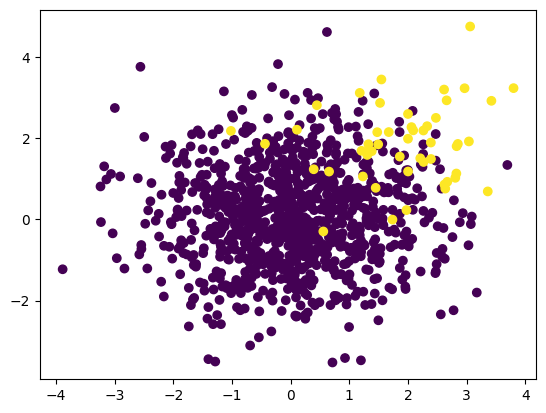

In [21]:
import matplotlib.pyplot as plt

n0 = 1000
n1 = 50

np.random.seed(42)
x1 = np.random.randn(n0, 2) * 1.2
x2 = np.random.randn(n1, 2) + [2, 2]

x = np.vstack([x1, x2])
y = np.array([0] * n0 + [1] * n1)

plt.scatter(x[:, 0], x[:, 1], c=y)
plt.show()

In [22]:
splits_stratified = split_to_k_folds(x, y, k=5, stratify=True)
splits = split_to_k_folds(x, y, k=5, stratify=False)

In [23]:
splits_stratified[0][0][0].shape, splits_stratified[0][1][0].shape, splits_stratified[0][1][1].shape

((840, 2), (210, 2), (210,))

In [24]:
splits[0][0][0].shape, splits[0][1][0].shape, splits[0][1][1].shape

((840, 2), (210, 2), (210,))

In [25]:
def print_class_distribution(splits, stratify=True):
    print("Class distribution in each fold:")
    for i, (train, test) in enumerate(splits):
        train_classes, train_counts = np.unique(train[1], return_counts=True)
        test_classes, test_counts = np.unique(test[1], return_counts=True)

        print(f"\nFold {i+1}:")
        print("Training set:")
        for cls, count in zip(train_classes, train_counts):
            print(f"  Class {cls}: {count} samples")

        print("Test set:")
        for cls, count in zip(test_classes, test_counts):
            print(f"  Class {cls}: {count} samples")

print("Stratified split:")
print_class_distribution(splits_stratified)

print("\nNon-stratified split:")
print_class_distribution(splits)


Stratified split:
Class distribution in each fold:

Fold 1:
Training set:
  Class 0: 800 samples
  Class 1: 40 samples
Test set:
  Class 0: 200 samples
  Class 1: 10 samples

Fold 2:
Training set:
  Class 0: 800 samples
  Class 1: 40 samples
Test set:
  Class 0: 200 samples
  Class 1: 10 samples

Fold 3:
Training set:
  Class 0: 800 samples
  Class 1: 40 samples
Test set:
  Class 0: 200 samples
  Class 1: 10 samples

Fold 4:
Training set:
  Class 0: 800 samples
  Class 1: 40 samples
Test set:
  Class 0: 200 samples
  Class 1: 10 samples

Fold 5:
Training set:
  Class 0: 800 samples
  Class 1: 40 samples
Test set:
  Class 0: 200 samples
  Class 1: 10 samples

Non-stratified split:
Class distribution in each fold:

Fold 1:
Training set:
  Class 0: 803 samples
  Class 1: 37 samples
Test set:
  Class 0: 197 samples
  Class 1: 13 samples

Fold 2:
Training set:
  Class 0: 797 samples
  Class 1: 43 samples
Test set:
  Class 0: 203 samples
  Class 1: 7 samples

Fold 3:
Training set:
  Class 0:

Przeprowadź walidację krzyżową dla klasyfikatora `GaussianNB` na danych z poprzedniego kroku. Porównaj wyniki dla obu wariantów podziału danych. Na podstawie obserwacji z poprzedniego zadania, wybierz miary oceny klasyfikatora, które uznasz za najbardziej adekwatne do tego zadania.

Poniższą komórkę możesz dowolnie modyfikować, aby np. obliczać kilka miar jednocześnie.

In [26]:
from sklearn.metrics import confusion_matrix

def binary_specifity(y_hat: np.ndarray, y: np.ndarray) -> float:
    """Funkcja obliczająca specyficzność klasyfikacji (specificity). Funkcja powinna wspierać klasyfikację binarną.

    Args:
        y_hat (np.ndarray): Macierz z predykacjami modelu o wymiarach `(n, 2)`.
        y (np.ndarray): Macierz z prawdziwymi klasami o wymiarach `(n, 2)`.

    Returns:
        float: Specyficzność klasyfikacji.
    """

    conf_matrix = confusion_matrix(y, y_hat)
    tn, fp = conf_matrix[0, 0], conf_matrix[0, 1]
    return tn / (tn + fp) if (tn + fp) > 0 else 0.0

In [27]:
from sklearn.naive_bayes import GaussianNB

metrics = {'accuracy': [], 'balanced_accuracy': [], 'g_mean': [], 'recall': [], 'specificity': []}

for (x_train, y_train), (x_test, y_test) in splits:
    model = GaussianNB()
    model.fit(x_train, y_train)
    y_hat = model.predict(x_test)

    metrics['accuracy'].append(accuracy_score(y_test, y_hat))
    metrics['balanced_accuracy'].append(balanced_accuracy_score(y_test, y_hat))
    metrics['g_mean'].append(geometric_mean_score(y_test, y_hat))
    metrics['recall'].append(recall_score(y_test, y_hat))
    metrics['specificity'].append(binary_specifity(y_hat, y_test))

print("Metrics for each fold:")
print(f"Accuracy: {np.mean(metrics['accuracy']):.4f} +/- {np.std(metrics['accuracy']):.4f}")
print(f"Balanced Accuracy: {np.mean(metrics['balanced_accuracy']):.4f} +/- {np.std(metrics['balanced_accuracy']):.4f}")
print(f"G-mean: {np.mean(metrics['g_mean']):.4f} +/- {np.std(metrics['g_mean']):.4f}")
print(f"Recall: {np.mean(metrics['recall']):.4f} +/- {np.std(metrics['recall']):.4f}")
print(f"Specificity: {np.mean(metrics['specificity']):.4f} +/- {np.std(metrics['specificity']):.4f}")

Metrics for each fold:
Accuracy: 0.9619 +/- 0.0117
Balanced Accuracy: 0.6784 +/- 0.0557
G-mean: 0.5947 +/- 0.0905
Recall: 0.3648 +/- 0.1113
Specificity: 0.9920 +/- 0.0040


### Pytania

Odpowiedz na pytania:
1. Jaka była Twoja motywacja do wybrania konkretnych miar klasyfikacji?

    - Dokładność jako taka podstawowa miara, zbalansowana dokładność żeby sprawdzić jak wypada dokładność z wyrównaniem wagi dla obu klas. G-mean żeby też żeby zobaczyć jak to wygląda łacznie dla obu klas. True positive rate i true negative rate żeby sprawdzić dla której klasy ma większy problem model. Ze względu że mamy tu do czynienia z klasyfikacją binarną to wykorzystałam metryki dostępne w sklearn, ponieważ w pierwszym zadaniu nie było to uwzględnione do zaimplementowania i już nie zdąże dopisać tej funkcjonalności, a jendak dla klasyfikacji binarnej nie sprawdzą się aż tak dobrze moim zdaniem miary z micro i macro averaging.

2. Dla jakich danych warto zastosować stratyfikację podczas walidacji krzyżowej?

    - Stratyfikację podczas walidacji krzyżowej warto zastosować w przypadku danych, które są niezrównoważone. Pomaga ona utrzymać proporcje klas w każdym z foldów, więc zapewnia że każdy z nich reprezentuje pełny rozkład klas, co może poprawić jakość oceny modelu.

3. Jakie ryzyko niesie za sobą losowy podział danych na dwa zbiory (treningowy i testowy), zamiast używania walidacji krzyżowej ze stratyfikacją?

    - Zwłaszcza w przypadku danych niezbilansowanych, losowy podział może prowadzić do nierealistycznych wyników, ponieważ np. do zbioru testowego może trafić zbyt mało przykładów klasy rzadkiej, co sprawi, że model oceni je bardzo dobrze, uzyskując nierealistycznie optymistyczny wynik(Może też się akurat trafić, że te klika przykładów będzie niepoprawnie zaklasyfikowanych i wynik będzie zbyt pesymistyczny). Wyrównanie rokładu klas do rzeczywistego poprawi nasze możliwości estymacji jakości modelu na nowych danych.